<img src="dcic.png">

# Mapping Inequality in Baltimore
Contributers : Sarah Agarrat and Richard Marciano 

## Introduction 

After the 1929 Stock Market Crash, thousands of Americans were in danger of home foreclosure. To address this problem and stabilize the market, The Home Owners Loan Coperation (HOLC) was created under the Rooselvelt Administration to asses credibility of families in order to decide to refinance their homes.
 
The HOLC created area descriptions and maps to "grade" neighborhoods based on racial/ethnic presence, the income of the residents, and environmental factors to determine their "financial risk". A grade of an 'A' (red) , was given to an area characterized as undesirable due to detrimental influences and unfavorable infiltration. Grade 'B' (yellow) areas were characterized by infiltration of a "lower grade population", "lacking homogeniety", and age of the neighborhoods, grade 'C' (blue) areas were completely developed, and 'grade 'D' (green) areas were characterized as "hot spots" that weren't fully built up yet and contained homogeinety. This is called __*redlining*__, denying financial services based on race/ethnic background.

 <img src="baltimoremap-min.png" alt="Baltimore security grade map" title="Baltimore Security Grade Map" width=600>

Learn more the Mapping Inequality Project [here.](https://dsl.richmond.edu/panorama/redlining/#loc=4/36.71/-96.93&opacity=0.8)

This notebook demonstrates computational techniques using attributes from the HOLC Baltimore records.  The topics covered are:
- Aquiring Data
- Data Cleaning and Data Preperation
- Data Manipulation
- Exploratory Data Analysis and Visualization 

## Aquiring Data

The fields of each record are characteristics of a graded section indicated by the security grade map seen above. These fields have been transcribed and stored in a __comma separated value (csv)__ format.

Using the pandas library, we can create a data frame from the csv. A __data frame__ is a table where every row represents a single unique object, called an __entity__, and every column represents characteristics of these objects, called __attributes__.

### Importing the Data and Creating a Data Frame

In [675]:
# loads the pandas library 
import pandas as pd

# creates data frame named df by reading in the Baltimore csv
df = pd.read_csv("AD_Data_BaltimoreProject.csv")
df.head(n=3)

,Form,State,City,Security_Grade,Area_Number,Terrain_Description,Favorable_Influences,Detrimental_Influences,INHABITANTS_Type,INHABITANTS_Annual_Income,...,INHABITANTS_Population_Increase,INHABITANTS_Population_Decrease,INHABITANTS_Population_Static,BUILDINGS_Types,BUILDINGS_Construction,BUILDINGS_Age,BUILDINGS_Repair,Ten_Fifteen_Desirability,Remarks,Date
0,NS FORM-8 6-1-37,Maryland,Baltimore,A,2,Rolling,Fairly new suburban area of homogeneous charac...,None,Substantial Middle Class,"$3000 - 5,000",...,Fast,NaN,NaN,Detached an row houses,Brick and frame,1 to 10 years,Good,Upward,A recent development with much room for expans...,"May 4,1937"
1,NS FORM-8 6-1-37,Maryland,Baltimore,A,1,Undulating,Very nicely planned residential area of medium...,None,"Executives, Professional Men",over $5000,...,Moderately Fast,NaN,NaN,Single family detached,Brick and Stone,12 years,Very good,Upward,Mostly fee properties. A few homes valued at $...,"May 4,1937"
2,NS FORM-8 6-1-37,Maryland,Baltimore,A,3,Rolling,Good residential area. Well planned.,Distance to City,"Executives, Professional Men",3500 - 7000,...,Moderately Fast,NaN,NaN,One family detached,"Brick, Stone, and Frame",1 to 20 years,Good to excellent,Upward,Principally fee property. This section lies in...,"May 4,1937"


<img src="Baltimore_AD_002.png" width=400 >

In this form, `SECUIRITY GRADE` has value A and `AREA NO.` has value 2. This form is located in the first row with index 0 in the data frame.

## Data Cleaning and Preparation 

After obtaining our data, we need to clean it to prepare for data analysis. This includes handling similiar text values and making sure a column of interest contains a single attribute.

### Handling Text Values with Similar Meanings 

The `INHABITANTS_Foreignborn` varaible indicates whether there are foreigners in a neighborhood section. Observe that different forms used 'No' or 'None' to indicate there are no foreigners and 'Small' , 'Very few' , and 'Mixture' are various ways of indicating there were foreigners. `NaN` indicates the value in the form is missing.

In [676]:
# selects rows with indices between 0 to 15 included of the 'INHABITANTS_Foreignborn' column
df.ix[0:15,'INHABITANTS_Foreignborn']

0           No
1         None
2         None
3         None
4         None
5          NaN
6           No
7           No
8           No
9        Small
10    Very few
11          No
12          No
13          No
14          No
15     Mixture
Name: INHABITANTS_Foreignborn, dtype: object

Since columns with categorized values are easier to analyze, we are going to transform this column to indicate whether there are foreigners or not. In Python, `None` is a special keyword that indicates the cell has a null value. Therefore, we will alter all the 'None' values to 'No' and every other value that indicates there are to 'Yes'.

In [677]:
# replaces the values of 'None' with 'No'
df['INHABITANTS_Foreignborn'] = df['INHABITANTS_Foreignborn'].replace('None', 'No')

# replaces all other values with 'Yes'
for value in df['INHABITANTS_Foreignborn']:
    if value != 'No' and value != 'NaN':
        df['INHABITANTS_Foreignborn'] = df['INHABITANTS_Foreignborn'].replace(value, 'Yes')

df.ix[0:15,'INHABITANTS_Foreignborn']

0      No
1      No
2      No
3      No
4      No
5     Yes
6      No
7      No
8      No
9     Yes
10    Yes
11     No
12     No
13     No
14     No
15    Yes
Name: INHABITANTS_Foreignborn, dtype: object

`Detrimental_Influences`  are descriptions of a region's undesiriable characteristics. Notice in this case that there are multiple variations of the meaning of 'No' to be replaced. 

In [678]:
df.ix[0:15,'Detrimental_Influences']

0                                          None
1                                          None
2                              Distance to City
3                                          None
4                                          None
5                                           NaN
6                                           No.
7                                          None
8     Few streets of property in poor condition
9                                          None
10                                         None
11                      Built on filled ground.
12                                         None
13                                         None
14                   Distance to center of city
15                                         None
Name: Detrimental_Influences, dtype: object

To handle the multiple words to be replaced we can use an __array__, a list that holds a fixed number of values of the same type, to store several strings. Then we can replace each occurence in `Detrimental_Influences` by iterating through the array and using the `replace()` function.

In [679]:
# declares an array called 'no_words' containing strings that all mean 'No'
no_words = ['No.','no', 'none', 'None']

# interates through no_words and replaces each occurence in Detrimental_Influences
for word in no_words:
    df['Detrimental_Influences'] = df['Detrimental_Influences'].replace( word , 'No')

In [680]:
df.ix[0:15,'Detrimental_Influences']

0                                            No
1                                            No
2                              Distance to City
3                                            No
4                                            No
5                                           NaN
6                                            No
7                                            No
8     Few streets of property in poor condition
9                                            No
10                                           No
11                      Built on filled ground.
12                                           No
13                                           No
14                   Distance to center of city
15                                           No
Name: Detrimental_Influences, dtype: object

We need to do these same operations for `INHABITANTS_Negro`, whether residents are African American, and `INHABITANTS_Infiltration`, which refers to if the area is being infiltrated. __Functions__ are procedures that perform specific tasks. In Python, we can create our own functions or used built-in functions such as `replace()`. __Parameters__ are variables that are defined in the function definition. __Arguments__ are the values passed into a function.

The `replace_values` function has three parmeters : `attribute`, `new_word`, and `words_to_replace`.

In [681]:
# this function iterates through an array of words to be replaced and replaces each occurence in the attribute 
# with the new word
def replace_values(attribute, new_word, words_to_replace):
    for word in words_to_replace:
        df[attribute] = df[attribute].replace(word, new_word) 


replace_values('INHABITANTS_Negro', 'No', no_words)
replace_values('INHABITANTS_Infiltration', 'No', no_words)

In [682]:
df.ix[0:15,'INHABITANTS_Infiltration']

0                  No
1                  No
2                  No
3                  No
4                  No
5                 NaN
6                  No
7                  No
8                  No
9                 NaN
10                 No
11                 No
12                 No
13                 No
14                 No
15    People from C-1
Name: INHABITANTS_Infiltration, dtype: object

Note that we do the same procedure for words meaning 'few', however we could have made these columns have two categories, 'yes' or 'no', and indicate in our data analysis the alterations to our data.

In [683]:
# Various words meaning small 
small_words = ['Nominal','nominal', 'Small','small','Minimum', 'minimum','minimal', 'Very few']

replace_values('INHABITANTS_Negro', 'Few', small_words)
replace_values('INHABITANTS_Infiltration', 'Few', small_words)

In [684]:
df.ix[0:15,'INHABITANTS_Infiltration']

0                  No
1                  No
2                  No
3                  No
4                  No
5                 NaN
6                  No
7                  No
8                  No
9                 NaN
10                 No
11                 No
12                 No
13                 No
14                 No
15    People from C-1
Name: INHABITANTS_Infiltration, dtype: object

In [685]:
df.ix[0:15,'INHABITANTS_Negro']

0      No
1      No
2      No
3      No
4      No
5     NaN
6      No
7      No
8      No
9      No
10     No
11     No
12     No
13     No
14     No
15     No
Name: INHABITANTS_Negro, dtype: object

We can clean up the values of `INHABITANTS_Population_Increase`, how the population is increasing in an area, by choosing standard categories for the rate the population.

In [686]:
 df.ix[0:15,'INHABITANTS_Population_Increase']

0               Fast 
1     Moderately Fast
2     Moderately Fast
3              Slowly
4     Moderately Fast
5                 NaN
6                 NaN
7              Slowly
8     Moderately Fast
9     Moderately Fast
10                NaN
11             Slowly
12             Slowly
13         Moderately
14             Slowly
15              Fast 
Name: INHABITANTS_Population_Increase, dtype: object

We will define rates of the population as very slowly, slowly, moderately, moderately fast, fast based on the data.

In [687]:
# defines values to replace in the table 
very_slowly = ['Very Slowly', 'very slowly', 'very Slowly']
slowly = ['slowly', 'fairly slowly']
moderately = ['moderately']
moderately_fast = ['Moderately Fast', 'moderately Fast', 'moderately fast']
fast = ['very fast', 'Very Fast', 'fast']

# applies function to obtain our new values 
replace_values('INHABITANTS_Population_Increase', 'Very slowly', very_slowly)
replace_values('INHABITANTS_Population_Increase', 'Slowly', slowly)
replace_values('INHABITANTS_Population_Increase', 'Moderately', moderately )
replace_values('INHABITANTS_Population_Increase', 'Moderately fast', moderately_fast)
replace_values('INHABITANTS_Population_Increase', 'Moderately fast', moderately_fast)
replace_values('INHABITANTS_Population_Increase', 'Fast', fast)


In [688]:
 df.ix[0:15,'INHABITANTS_Population_Increase']

0               Fast 
1     Moderately fast
2     Moderately fast
3              Slowly
4     Moderately fast
5                 NaN
6                 NaN
7              Slowly
8     Moderately fast
9     Moderately fast
10                NaN
11             Slowly
12             Slowly
13         Moderately
14             Slowly
15              Fast 
Name: INHABITANTS_Population_Increase, dtype: object

### String Parsing to Extract Data

Some of the cities have corresponding suburbs followed by a dash. We can extract the suburbs and create a new column using  `str.split()`.

In [689]:
df.ix[16:30,'City']

16                                Baltimore 
17                       Baltimore - Dundalk
18                                 Baltimore
19                  Baltimore - Metropolitan
20                                 Baltimore
21                  Baltimore - Metropolitan
22                                 Baltimore
23                   Baltimore - Sub. Burton
24    Baltimore - Sub. Mt. Washington Summit
25                Baltimore - Sub. Villahove
26            Baltimore - Sub. Colonial Park
27        Baltimore - Sub. Linthicum Heights
28                                 Baltimore
29                                 Baltimore
30                                 Baltimore
Name: City, dtype: object

 A new data frame seperate is created with two columns seperated based on `str.split`, where `n=1` indicates the string is split once. We create two new attributes in the original data frame, `City_clean` and `Suburb`. Then we drop the old `City` city column and rename our new `City` attribute.

In [690]:
# creates a new data frame that splits the values in the orginal data frame on the '-' character 
newdf = df["City"].str.split('-', n = 1, expand = True) 
newdf.head()

# creates two new columns 
df['City_clean'] = newdf[0]
df['Suburb'] = newdf[1]

# removes the old column
df.drop(["City"], axis = 1, inplace = True) 

# renames as 'City'
df.rename(index=str, columns={"City_clean": "City"});

In [691]:
df.ix[16:30,['Suburb']]

,Suburb
16,None
17,Dundalk
18,None
19,Metropolitan
20,None
21,Metropolitan
22,None
23,Sub. Burton
24,Sub. Mt. Washington Summit
25,Sub. Villahove


The `BUILDINGS_Age` attribute represents the range of the age of the buildings in a region. Notice the range is given is given as a string of text. For purpose of analysis, we would like to extract the upper end of the range and create a column of numeric values.

In [692]:
df.ix[0:15,'BUILDINGS_Age']

0      1 to 10 years
1           12 years
2      1 to 20 years
3           10 years
4      1 to 20 years
5                NaN
6           25 years
7     15 to 25 years
8           15 years
9      5 to 25 years
10          20 years
11     5 to 10 years
12          10 years
13          25 years
14     1 to 20 years
15     6 to 25 years
Name: BUILDINGS_Age, dtype: object

Observe that the numeric value at the end of the range is always the last number followed by the string `years`. We use specific string patterns called __regular expressions (regex)__ and `str.extract()` to create a new attribute called `max_building_age`.

In [693]:
df['max_building_age'] = df['BUILDINGS_Age'].str.extract('(\d+)(?!.*\d)', expand=True)

The regular expression in this example is `(\d+)(?!.*\d)` and was tested using [Pythex](https://pythex.org/), a regex editor. We could have imported `re` , Python's regular expression library, to perform the same task, however this notebook consistenly uses `str()` functions.

In [694]:
df.ix[0:15,['BUILDINGS_Age','max_building_age']]

,BUILDINGS_Age,max_building_age
0,1 to 10 years,10
1,12 years,12
2,1 to 20 years,20
3,10 years,10
4,1 to 20 years,20
5,NaN,NaN
6,25 years,25
7,15 to 25 years,25
8,15 years,15
9,5 to 25 years,25


 The `Date`, the date indicated on the form, has three attributes with the pattern given by **month day, year**. As previously stated, we would like to have a single attribute per column.

In [695]:
df.ix[0:3,['Date']]

,Date
0,"May 4,1937"
1,"May 4,1937"
2,"May 4,1937"
3,"May 4,1937"


We can seperate this column into three columns:  `Month`, `Day`, and `Year` using `str.extract()` and regex patterns
`(\d\d\d\d)` to indicate four digit year, `(\d)` to indicate a single digit day, and ` [A-Z]\w{0,}` to indicate __aplhanumeric__ text to extract the month. Note that regex can also be used to reformat the date column.

In [696]:
# extracts the year 
df['Year'] = df['Date'].str.extract('(\d\d\d\d)', expand=True)

# extracts day  
df['Day'] = df['Date'].str.extract('(\d)', expand=True)

# extracts month 
df['Month'] = df['Date'].str.extract('([A-Z]\w{0,})', expand=True)

df.ix[0:3,['Date','Month','Day','Year']]

,Date,Month,Day,Year
0,"May 4,1937",May,4,1937
1,"May 4,1937",May,4,1937
2,"May 4,1937",May,4,1937
3,"May 4,1937",May,4,1937


Similar to `BUILDINGS_Age`, `INHABITANTS_Annual_Income`, the range of income of residents in a section, is a string of text and we would like to extract the numeric value at the end of the range.

In [697]:
df.ix[0:7,['INHABITANTS_Annual_Income']]

,INHABITANTS_Annual_Income
0,"$3000 - 5,000"
1,over $5000
2,3500 - 7000
3,over $5000
4,"$3,500 - $10,000"
5,NaN
6,over $4000
7,over $5000


Observe that some values are located after '$', some inlcude '-', and others include ','.Since the pattern to extract the last numeric value varies, we use `str.replace()`, `str.extract`, and regex in a sequence of operations to create a new column `max_annual_income`.

In [698]:
# replaces anything that is not a digit or ',' with empty space
df['max_annual_income'] = df['INHABITANTS_Annual_Income'].str.replace('[^\d(,)]',' ')

In [699]:
df.ix[0:7,['max_annual_income']]

,max_annual_income
0,"3000 5,000"
1,5000
2,3500 7000
3,5000
4,"3,500 10,000"
5,NaN
6,4000
7,5000


We did not include the delimeter in the previous `str.replace()` operation because their positions would have been replaced by an empty space. Now we want to remove delimeters.

In [700]:
# removes delimeter by replacing ',' with ''
df['max_annual_income'] = df['max_annual_income'].str.replace('[(,)]','')

In [701]:
df.ix[0:7,['max_annual_income']]

,max_annual_income
0,3000 5000
1,5000
2,3500 7000
3,5000
4,3500 10000
5,NaN
6,4000
7,5000


Finally, we can extract the last number.

In [702]:
# extracts the second or last number 
df['max_annual_income'] = df['max_annual_income'].str.extract('(\d+)(?!.*\d)', expand=True)

In [703]:
df.ix[0:7,['max_annual_income']]

,max_annual_income
0,5000
1,5000
2,7000
3,5000
4,10000
5,NaN
6,4000
7,5000


## Data Manipulation 

Some aspects of __data manipulation__, altering data to make it easier to read or use, include sorting and grouping attributes and encoding categorical variables.

### Sorting and Grouping 

The values of `Area_Number` are out of order and we want these values to be sorted by `Security_Grade`. 

In [704]:
# removes any additional spaces from Security_Grade
df['Security_Grade'] = df['Security_Grade'].str.replace('[\W]','')
# converts 'Area_Number' from type object to type 'numeric'
df['Area_Number'] = pd.to_numeric(df['Area_Number'])
df.ix[0:10,['Security_Grade','Area_Number']]

,Security_Grade,Area_Number
0,A,2
1,A,1
2,A,3
3,A,4
4,A,5
5,A,6
6,B,1
7,B,2
8,B,3
9,B,4


To do this, we created use the `sort_values()` function on the original data frame and reset the index. First, the data is sorted and grouped by `Security_Grade` and then `Area_Number` is sorted in increasing order.

In [705]:
df = df.sort_values(by=['Security_Grade', 'Area_Number'])
# resets the index starting from 0
df = df.reset_index(drop=True)
df.ix[0:10,['Security_Grade','Area_Number']]

,Security_Grade,Area_Number
0,A,1
1,A,2
2,A,3
3,A,4
4,A,5
5,A,6
6,B,1
7,B,2
8,B,3
9,B,4


### Encoding Categorical Data

In [706]:
 df.ix[0:15,'INHABITANTS_Population_Increase']

0     Moderately fast
1               Fast 
2     Moderately fast
3              Slowly
4     Moderately fast
5                 NaN
6                 NaN
7              Slowly
8     Moderately fast
9     Moderately fast
10                NaN
11             Slowly
12             Slowly
13         Moderately
14             Slowly
15              Fast 
Name: INHABITANTS_Population_Increase, dtype: object

## Exploratory Data Analysis and Visualization

The goal of __exploratory data analysis (EDA)__ is to explore attributes across multiple entities to decide what statistical or machine learning techniques to apply to the data. Visualizations are used to assist in understanding the data.

The `.describe()` function summarizes a data frame column. Since the data type of `max_building_age` is currently type 'object', which in python is an indcator of type 'string', we have to first convert this attribute into a numeric value.

In [707]:
df['max_building_age'].describe()

count     46
unique    12
top       25
freq       9
Name: max_building_age, dtype: object

Now that `max_building_age` is numeric type, we see that `describe()` provides __summary statistics__ on this attribute.

In [708]:
# converts max_building age to numeric type
df["max_building_age"] = pd.to_numeric(df["max_building_age"])
df['max_building_age'].describe()

count    46.000000
mean     30.086957
std      16.497577
min      10.000000
25%      20.000000
50%      25.000000
75%      40.000000
max      65.000000
Name: max_building_age, dtype: float64

We can the same operations to `max_annual_income`.

In [709]:
df['max_annual_income'].describe()

count       46
unique      12
top       2500
freq         8
Name: max_annual_income, dtype: object

In [710]:
df['max_annual_income'] = pd.to_numeric(df['max_annual_income'])
df['max_annual_income'].describe()

count       46.000000
mean      3139.130435
std       2009.806874
min       1000.000000
25%       1850.000000
50%       2750.000000
75%       4000.000000
max      10000.000000
Name: max_annual_income, dtype: float64

Finally we create some plots our data. A __scatter plot__ and a __bar chart__ are shown below.

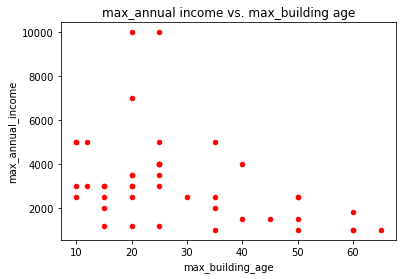

In [734]:
df.plot(kind='scatter',x='max_building_age',y='max_annual_income',color='red', title='max_annual income vs. max_building age')
plt.show()

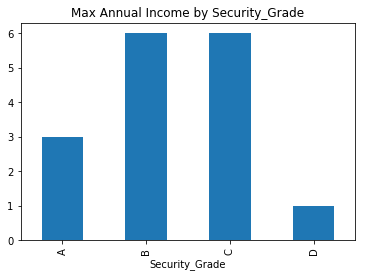

In [730]:
df.groupby('Security_Grade')['max_annual_income'].nunique().plot(kind='bar', title='Max Annual Income by Security_Grade')
plt.show()

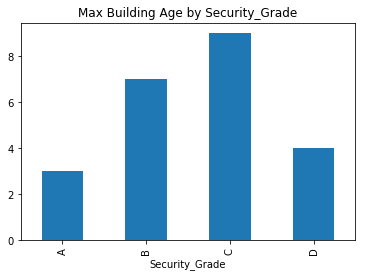

In [731]:
df.groupby('Security_Grade')['max_building_age'].nunique().plot(kind='bar', title='Max Building Age by Security_Grade')
plt.show()